<a href="https://colab.research.google.com/github/MariannaMois/pet_project/blob/master/gender_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Модель прогноза пола pet-project

Курс ML Олега Булыгина. Возвращаемся к данным по поссумам 🐻

Задание. Разработайте и реализуйте архитектуру нейросети для прогноза пола при помощи PyTorch. Метрика качества: F1-score.

Поработаем с [данными](https://github.com/obulygin/content/blob/main/possum_data/possum.csv) по физиологическим показателям поссумов ^_^

Вам необходимо:  
1) Прочитать данные. Признак site нам не нужен - это номер ловушки, в которую был пойман поссум.   
2) Проверить, есть ли в них проблемы, которые помешают дальнейшей работе (пропуски, аномалии, некорректные типы данных).  
3) Пострить модель, которая наиболее хорошо будет определять пол поссума по выбранным параметрам. В качестве метрики качества используем F1-score, также необходимо построить матрицу ошибок.  
4) Написать выводы о том, какие параметры наиболее значимы для определения пола поссума.

Вы можете использовать любые инструменты подготовки данных, модели и способы их оптимизации, которые вам известны. Единственный критерий - максимизация метрики качества корректными способами.


*Сопровождайте все действия, которые могут предполагать альтернативные способы реализации, обоснованием*.

# Исследование параметров поссумов

*Цель*
Построить модель, которая наилучшим образом определяет пол поссума по морфометрическим параметрам.
*Задачи:*
Загрузить и изучить данные, проверить наличие проблем, которые могут помешать дальнейшей работе (пропуски, аномалии, некорректные типы данных).
Подготовить данные для моделирования.
Построить модель классификации пола поссума.
Оценить качество модели с использованием метрики F1-score и построить матрицу ошибок.
Провести анализ значимости признаков для определения пола поссума.

*Описание данных*
Датасет содержит следующую информацию о поссумах:
sex: пол (m — самец, f — самка)
age: возраст
hdlngth: длина головы
skullw: ширина черепа
totlngth: общая длина
taill: длина хвоста
footlgth: длина стопы
earconch: размер ушной раковины
eye: размер глаза
chest: обхват груди
belly: обхват живота

Признак site (номер ловушки, в которую был пойман поссум) не используется в модели.

# EDA

In [ ]:
!pip install skorch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
data_url = 'https://raw.githubusercontent.com/obulygin/content/main/possum_data/possum.csv'
df = pd.read_csv(data_url)

In [ ]:
df.head()

,Unnamed: 0,site,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,0,1,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,1,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,2,1,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,3,1,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,4,1,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  104 non-null    int64  
 1   site        104 non-null    int64  
 2   sex         104 non-null    object 
 3   age         102 non-null    float64
 4   hdlngth     104 non-null    float64
 5   skullw      104 non-null    float64
 6   totlngth    104 non-null    float64
 7   taill       104 non-null    float64
 8   footlgth    103 non-null    float64
 9   earconch    104 non-null    float64
 10  eye         104 non-null    float64
 11  chest       104 non-null    float64
 12  belly       104 non-null    float64
dtypes: float64(10), int64(2), object(1)
memory usage: 10.7+ KB


In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
site,0
sex,0
age,2
hdlngth,0
skullw,0
totlngth,0
taill,0
footlgth,1
earconch,0


In [ ]:
df.describe()

,Unnamed: 0,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,104.000000,104.000000,102.000000,104.000000,104.000000,104.000000,104.000000,103.000000,104.000000,104.000000,104.000000,104.000000
mean,51.500000,3.625000,3.833333,92.602885,56.883654,87.088462,37.009615,68.459223,48.130769,15.046154,27.000000,32.586538
std,30.166206,2.349086,1.909244,3.573349,3.113426,4.310549,1.959518,4.395306,4.109380,1.050374,2.045597,2.761949
min,0.000000,1.000000,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,25.750000,1.000000,2.250000,90.675000,54.975000,84.000000,35.875000,64.600000,44.800000,14.400000,25.500000,31.000000
50%,51.500000,3.000000,3.000000,92.800000,56.350000,88.000000,37.000000,68.000000,46.800000,14.900000,27.000000,32.500000
75%,77.250000,6.000000,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,103.000000,7.000000,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


Из результатов видно, что в данных присутствуют пропуски, которые необходимо обработать или удалить. Однако возраст с высокой долей вероятности, не окажет влияние на пол поссума, поэтому пропуски можно было не обрабатывать.

In [ ]:
df = df.dropna().reset_index(drop=True)

In [ ]:
#numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
#df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

In [ ]:
df['sex'] = df['sex'].map({'m': 1, 'f': 0})

In [ ]:
df

,Unnamed: 0,site,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,0,1,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,1,0,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,2,1,0,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,3,1,0,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,4,1,0,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,99,7,1,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0
97,100,7,1,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0
98,101,7,0,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0
99,102,7,1,4.0,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0


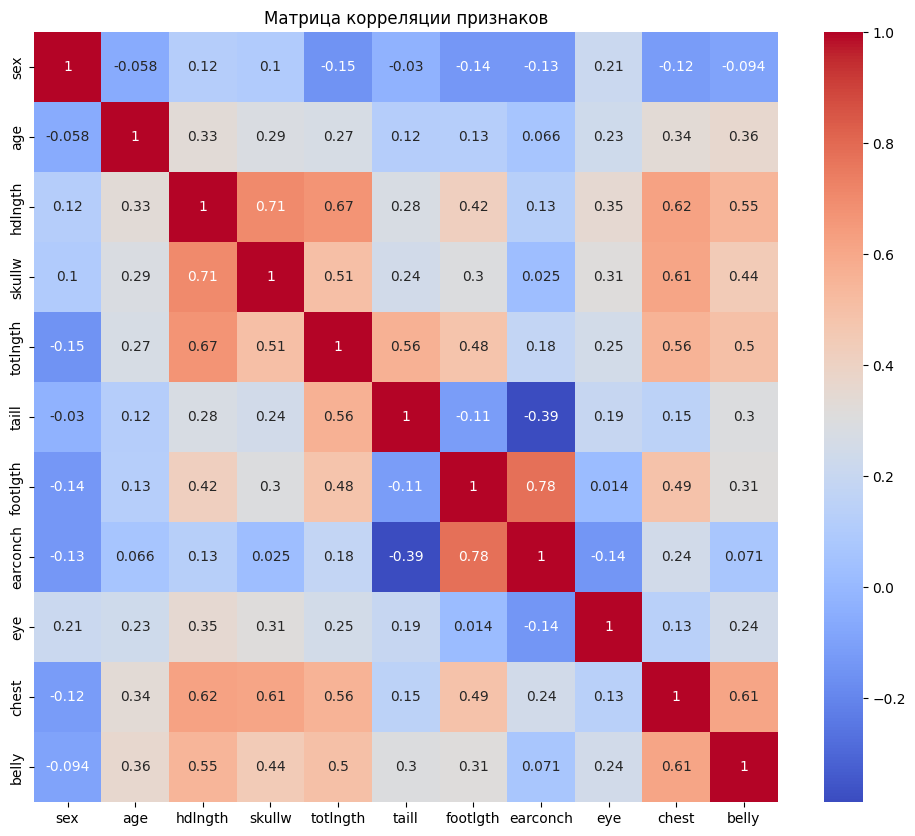

In [ ]:
plt.figure(figsize=(12,10))
corr_matrix = df.drop(['site', 'Unnamed: 0'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции признаков')
plt.show()

Из матрицы корреляции видно, что некоторые признаки сильно коррелируют между собой. Например:
hdlngth и skullw, totlngth и taill, totlngth и hdlngth, taill и footlgth.

Добавим новые признаки, соотношение длины головы к ширине черепа или длины хвоста к общей длине.

In [ ]:
df['head_to_skull_ratio'] = df['hdlngth'] / df['skullw']
df['tail_to_total_length_ratio'] = df['taill'] / df['totlngth']

In [ ]:
X = df.drop(['sex'], axis=1)
y = df['sex']

# Масштабирование данных

In [ ]:
from sklearn.preprocessing import StandardScaler


X_reduced = df.drop(['Unnamed: 0', 'sex', 'site', 'age', 'skullw', 'taill', 'earconch', 'belly'], axis=1)
X = X
y = df['sex']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X = X_reduced
y = df['sex']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.35, random_state=42
)

# Построение модели

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
from sklearn.metrics import f1_score

# Предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Расчет F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.2f}")

F1-score: 0.76


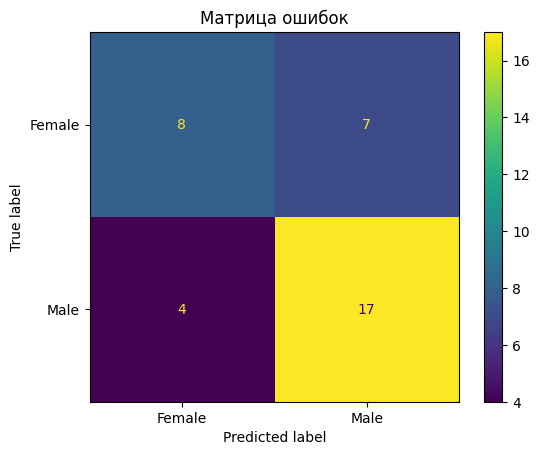

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Female', 'Male'])
cmd.plot()
plt.title('Матрица ошибок')
plt.show()

In [ ]:
coefficients = pd.DataFrame({
    'Признак': X.columns,
    'Коэффициент': model.coef_[0]
})

coefficients['Абс_коэффициент'] = coefficients['Коэффициент'].abs()
coefficients.sort_values(by='Абс_коэффициент', ascending=False, inplace=True)

coefficients.drop('Абс_коэффициент', axis=1, inplace=True)

coefficients

,Признак,Коэффициент
0,hdlngth,0.735695
1,totlngth,-0.687421
4,chest,-0.406819
3,eye,0.378250
5,head_to_skull_ratio,-0.094949
2,footlgth,0.088030
6,tail_to_total_length_ratio,-0.043184


Наиболее значимые признаки для определения пола поссума: eye (размер глаза),hdlngth (длина головы), earconch (размер ушной раковины)

# Подготовка данных для PyTorch

In [ ]:
import torch
from torch import nn
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Определение улучшенной архитектуры нейросети
class ImprovedPossumNet(nn.Module):
    def __init__(self):
        super(ImprovedPossumNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        out = self.dropout1(self.relu1(self.fc1(x)))
        out = self.dropout2(self.relu2(self.fc2(out)))
        out = self.fc3(out)
        return out

In [ ]:
# Функция для обучения модели
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

In [ ]:
# Функция для оценки модели
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    f1 = f1_score(all_labels, all_preds)
    print(f'F1-score: {f1:.4f}')
    cm = confusion_matrix(all_labels, all_preds)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Female', 'Male'])
    cmd.plot()
    plt.title('Матрица ошибок')
    plt.show()
    return f1

In [ ]:
# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

Epoch [1/100], Loss: 0.6924
Epoch [2/100], Loss: 0.6936
Epoch [3/100], Loss: 0.6784
Epoch [4/100], Loss: 0.6801
Epoch [5/100], Loss: 0.6834
Epoch [6/100], Loss: 0.6850
Epoch [7/100], Loss: 0.6975
Epoch [8/100], Loss: 0.6837
Epoch [9/100], Loss: 0.6745
Epoch [10/100], Loss: 0.6802
Epoch [11/100], Loss: 0.6600
Epoch [12/100], Loss: 0.6693
Epoch [13/100], Loss: 0.6642
Epoch [14/100], Loss: 0.6785
Epoch [15/100], Loss: 0.6526
Epoch [16/100], Loss: 0.6506
Epoch [17/100], Loss: 0.6628
Epoch [18/100], Loss: 0.6632
Epoch [19/100], Loss: 0.6623
Epoch [20/100], Loss: 0.6559
Epoch [21/100], Loss: 0.6611
Epoch [22/100], Loss: 0.6632
Epoch [23/100], Loss: 0.6530
Epoch [24/100], Loss: 0.6426
Epoch [25/100], Loss: 0.6415
Epoch [26/100], Loss: 0.6336
Epoch [27/100], Loss: 0.6532
Epoch [28/100], Loss: 0.6298
Epoch [29/100], Loss: 0.6391
Epoch [30/100], Loss: 0.6369
Epoch [31/100], Loss: 0.6455
Epoch [32/100], Loss: 0.6432
Epoch [33/100], Loss: 0.6350
Epoch [34/100], Loss: 0.6264
Epoch [35/100], Loss: 0

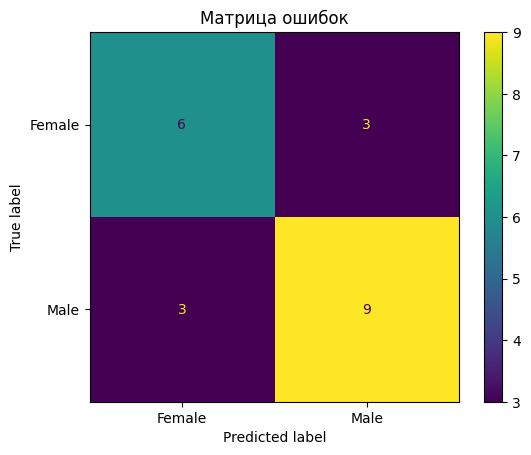

Epoch [1/100], Loss: 0.6860
Epoch [2/100], Loss: 0.6988
Epoch [3/100], Loss: 0.6925
Epoch [4/100], Loss: 0.6872
Epoch [5/100], Loss: 0.6871
Epoch [6/100], Loss: 0.6889
Epoch [7/100], Loss: 0.6848
Epoch [8/100], Loss: 0.6706
Epoch [9/100], Loss: 0.6628
Epoch [10/100], Loss: 0.6680
Epoch [11/100], Loss: 0.6565
Epoch [12/100], Loss: 0.6641
Epoch [13/100], Loss: 0.6444
Epoch [14/100], Loss: 0.6564
Epoch [15/100], Loss: 0.6646
Epoch [16/100], Loss: 0.6325
Epoch [17/100], Loss: 0.6527
Epoch [18/100], Loss: 0.6474
Epoch [19/100], Loss: 0.6456
Epoch [20/100], Loss: 0.6496
Epoch [21/100], Loss: 0.6427
Epoch [22/100], Loss: 0.6374
Epoch [23/100], Loss: 0.6340
Epoch [24/100], Loss: 0.6415
Epoch [25/100], Loss: 0.6452
Epoch [26/100], Loss: 0.6151
Epoch [27/100], Loss: 0.6268
Epoch [28/100], Loss: 0.6205
Epoch [29/100], Loss: 0.5995
Epoch [30/100], Loss: 0.6166
Epoch [31/100], Loss: 0.6035
Epoch [32/100], Loss: 0.6202
Epoch [33/100], Loss: 0.6022
Epoch [34/100], Loss: 0.5889
Epoch [35/100], Loss: 0

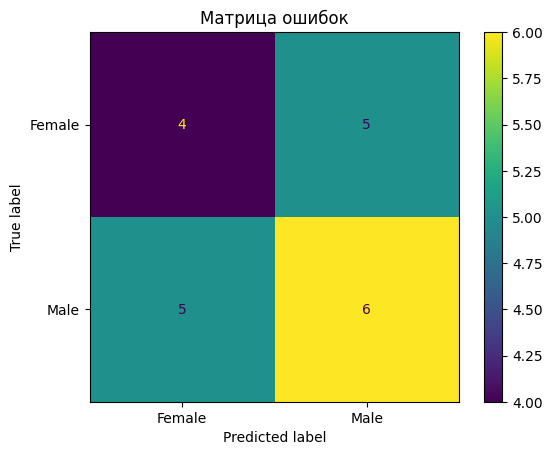

Epoch [1/100], Loss: 0.6902
Epoch [2/100], Loss: 0.6648
Epoch [3/100], Loss: 0.6743
Epoch [4/100], Loss: 0.6611
Epoch [5/100], Loss: 0.6738
Epoch [6/100], Loss: 0.6594
Epoch [7/100], Loss: 0.6600
Epoch [8/100], Loss: 0.6565
Epoch [9/100], Loss: 0.6645
Epoch [10/100], Loss: 0.6713
Epoch [11/100], Loss: 0.6525
Epoch [12/100], Loss: 0.6585
Epoch [13/100], Loss: 0.6553
Epoch [14/100], Loss: 0.6395
Epoch [15/100], Loss: 0.6274
Epoch [16/100], Loss: 0.6396
Epoch [17/100], Loss: 0.6335
Epoch [18/100], Loss: 0.6353
Epoch [19/100], Loss: 0.6419
Epoch [20/100], Loss: 0.6620
Epoch [21/100], Loss: 0.6330
Epoch [22/100], Loss: 0.6642
Epoch [23/100], Loss: 0.6445
Epoch [24/100], Loss: 0.6356
Epoch [25/100], Loss: 0.6519
Epoch [26/100], Loss: 0.6336
Epoch [27/100], Loss: 0.6344
Epoch [28/100], Loss: 0.6228
Epoch [29/100], Loss: 0.6323
Epoch [30/100], Loss: 0.6227
Epoch [31/100], Loss: 0.6386
Epoch [32/100], Loss: 0.6243
Epoch [33/100], Loss: 0.6235
Epoch [34/100], Loss: 0.6201
Epoch [35/100], Loss: 0

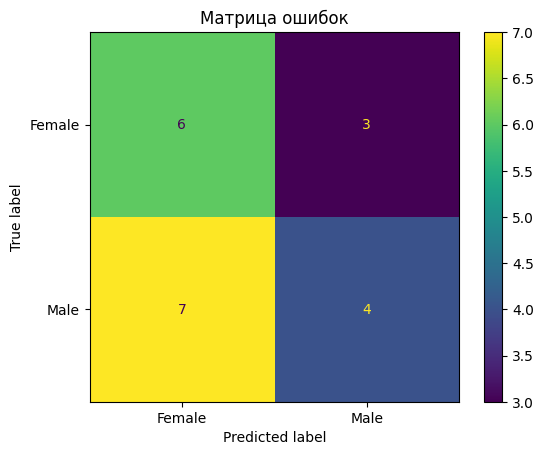

Epoch [1/100], Loss: 0.6947
Epoch [2/100], Loss: 0.6893
Epoch [3/100], Loss: 0.6878
Epoch [4/100], Loss: 0.7079
Epoch [5/100], Loss: 0.7001
Epoch [6/100], Loss: 0.6999
Epoch [7/100], Loss: 0.6903
Epoch [8/100], Loss: 0.6831
Epoch [9/100], Loss: 0.6749
Epoch [10/100], Loss: 0.6702
Epoch [11/100], Loss: 0.6769
Epoch [12/100], Loss: 0.6872
Epoch [13/100], Loss: 0.6702
Epoch [14/100], Loss: 0.6645
Epoch [15/100], Loss: 0.6572
Epoch [16/100], Loss: 0.6500
Epoch [17/100], Loss: 0.6692
Epoch [18/100], Loss: 0.6647
Epoch [19/100], Loss: 0.6718
Epoch [20/100], Loss: 0.6549
Epoch [21/100], Loss: 0.6810
Epoch [22/100], Loss: 0.6499
Epoch [23/100], Loss: 0.6410
Epoch [24/100], Loss: 0.6487
Epoch [25/100], Loss: 0.6326
Epoch [26/100], Loss: 0.6436
Epoch [27/100], Loss: 0.6456
Epoch [28/100], Loss: 0.6562
Epoch [29/100], Loss: 0.6461
Epoch [30/100], Loss: 0.6322
Epoch [31/100], Loss: 0.6411
Epoch [32/100], Loss: 0.6371
Epoch [33/100], Loss: 0.6553
Epoch [34/100], Loss: 0.6678
Epoch [35/100], Loss: 0

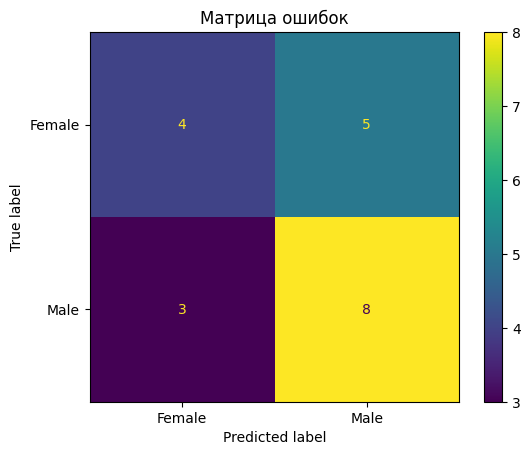

Epoch [1/100], Loss: 0.6949
Epoch [2/100], Loss: 0.6928
Epoch [3/100], Loss: 0.7010
Epoch [4/100], Loss: 0.6805
Epoch [5/100], Loss: 0.6827
Epoch [6/100], Loss: 0.6814
Epoch [7/100], Loss: 0.6904
Epoch [8/100], Loss: 0.6886
Epoch [9/100], Loss: 0.6914
Epoch [10/100], Loss: 0.6678
Epoch [11/100], Loss: 0.6683
Epoch [12/100], Loss: 0.6849
Epoch [13/100], Loss: 0.6697
Epoch [14/100], Loss: 0.6637
Epoch [15/100], Loss: 0.6839
Epoch [16/100], Loss: 0.6761
Epoch [17/100], Loss: 0.6469
Epoch [18/100], Loss: 0.6747
Epoch [19/100], Loss: 0.6522
Epoch [20/100], Loss: 0.6610
Epoch [21/100], Loss: 0.6724
Epoch [22/100], Loss: 0.6654
Epoch [23/100], Loss: 0.6721
Epoch [24/100], Loss: 0.6566
Epoch [25/100], Loss: 0.6468
Epoch [26/100], Loss: 0.6607
Epoch [27/100], Loss: 0.6683
Epoch [28/100], Loss: 0.6394
Epoch [29/100], Loss: 0.6679
Epoch [30/100], Loss: 0.6483
Epoch [31/100], Loss: 0.6373
Epoch [32/100], Loss: 0.6463
Epoch [33/100], Loss: 0.6427
Epoch [34/100], Loss: 0.6379
Epoch [35/100], Loss: 0

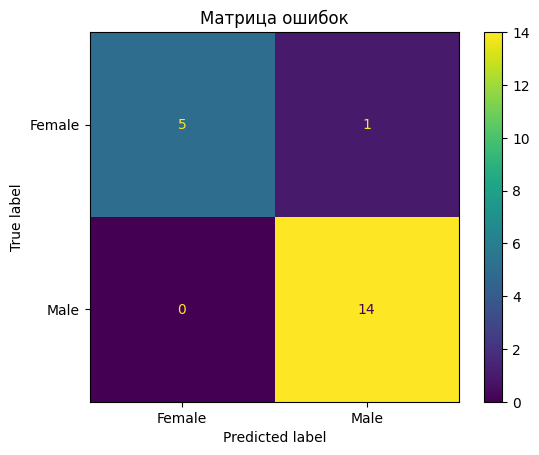

Средний F1-score по кросс-валидации: 0.6744


In [ ]:
for train_index, val_index in kf.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Конвертация в тензоры
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.long)

    # Создание даталоадеров
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Установите значение batch_size
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Инициализация модели, функции потерь и оптимизатора
    model = ImprovedPossumNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Обучение модели
    train_model(model, train_loader, criterion, optimizer, num_epochs=100)

    # Оценка модели
    f1 = evaluate_model(model, val_loader)
    f1_scores.append(f1)

# Средний F1-score по всем фолдам
mean_f1_score = np.mean(f1_scores)
print(f'Средний F1-score по кросс-валидации: {mean_f1_score:.4f}')

Улучшение архитектуры нейросети

In [ ]:
# Определение улучшенной архитектуры нейросети
class ImprovedPossumNet(nn.Module):
    def __init__(self, num_units=32, dropout=0.5):
        super(ImprovedPossumNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], num_units)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(num_units, num_units // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(num_units // 2, 2)

    def forward(self, x):
        out = self.dropout1(self.relu1(self.fc1(x)))
        out = self.dropout2(self.relu2(self.fc2(out)))
        out = self.fc3(out)
        return out

In [ ]:
# Создание экземпляра модели для skorch
net = NeuralNetClassifier(
    ImprovedPossumNet,
    max_epochs=100,
    lr=0.01,
    batch_size=16,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    callbacks=[EarlyStopping(patience=5)],
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [ ]:
# Определение параметров для поиска
params = {
    'lr': [0.001, 0.01, 0.1],
    'max_epochs': [50, 100, 200],
    'module__num_units': [16, 32, 64],
    'module__dropout': [0.3, 0.5, 0.7],
    'batch_size': [16, 32, 64]
}

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7109       0.5714        0.6562  0.0132
      2        0.6941       0.5714        0.6562  0.0197
      3        0.6683       0.5714        0.6569  0.0178
      4        0.6819       0.5714        0.6570  0.0122
      5        0.6594       0.5714        0.6568  0.0331
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7090       0.5714        0.6806  0.0114
      2        0.6929       0.5714        0.6803  0.0127
      3        0.8207       0.5714        0.6801  0.0194
      4        0.7119       0.5714        0.6798  0.0222
      5        0.7011       0.5714        0.6795  0.0150
      6        0.7153       0.5714        0.6794  0.0119
      7        0.7401       0.5714        0.6792  0.0152
      8        0.6902  

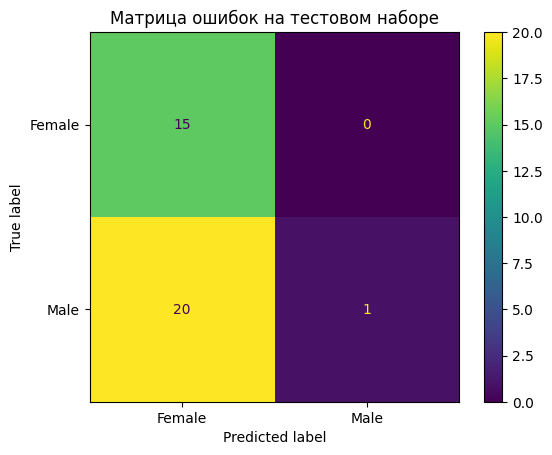

In [ ]:
# Использование RandomizedSearchCV для поиска гиперпараметров
rs = RandomizedSearchCV(net, params, refit=True, cv=3, scoring='f1', n_iter=10, random_state=42)
rs.fit(X_scaled.astype(np.float32), y.values.astype(np.int64))  # Изменено с np.long на np.int64

# Вывод лучших параметров и F1-score
print(f"Лучшие параметры: {rs.best_params_}")
print(f"Лучший F1-score: {rs.best_score_:.4f}")

# Конвертация тестового набора в тензоры
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Оценка модели на тестовом наборе
y_pred = rs.predict(X_test_tensor)
f1 = f1_score(y_test, y_pred)
print(f"F1-score на тестовом наборе: {f1:.4f}")

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Female', 'Male'])
cmd.plot()
plt.title('Матрица ошибок на тестовом наборе')
plt.show()

Данные, рассчитанные с использованием PyTorch и данные базовой модели логистической регрессии дают близкие по качеству модели. Матрица ошибок показывает, что чаще модель неверно определяет пол самцов.